<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

## <center>Домашнее задание №8</center>
## <center>Xgboost и данные Samsung по типу активности людей. Решение</center>

In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
%load_ext watermark

In [3]:
%watermark -v -m -p numpy,pandas,sklearn

CPython 3.6.1
IPython 5.1.0

numpy 1.12.1
pandas 0.19.2
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.4.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [6]:
RANDOM_SEED = 17

**Считываем [данные](https://yadi.sk/d/ha-lprkDvozGx) Samsung Human Activity Recognition. Почитайте [описание](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) эксперимента. Вкратце: задача – прогнозировать тип активности человека (ходьба, ходьба вверх по лестнице, вниз по лестнице, сидение, стояние и лежание) по данным с акселерометра и гироскопа его смартфона (Samsung Galaxy S3). **

In [5]:
# поменяйте пути к файлам
import os
DATA_PATH = '../../../module2_ML/data'
X_train = np.loadtxt(os.path.join(DATA_PATH, 'samsung_train.txt'))
y_train = np.loadtxt(os.path.join(DATA_PATH, 'samsung_train_labels.txt')).astype(int)
X_test = np.loadtxt(os.path.join(DATA_PATH, 'samsung_test.txt'))
y_test = np.loadtxt(os.path.join(DATA_PATH, 'samsung_test_labels.txt')).astype(int)

In [7]:
X_train.shape, X_test.shape

((7352, 561), (2947, 561))

**Видим, что распределение классов (типов активностей) довольно равномерно.**

In [8]:
np.bincount(y_train), np.bincount(y_test)

(array([   0, 1226, 1073,  986, 1286, 1374, 1407]),
 array([  0, 496, 471, 420, 491, 532, 537]))

**Выделим столько главных компонент, чтоб осталось 90% дисперсии исходных данных.**

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(0.9)
X_train_pca = pca.fit_transform(X_train_scaled)
print(X_train_pca.shape)

X_test_pca = pca.transform(scaler.transform(X_test))
print(X_test_pca.shape)

(7352, 63)
(2947, 63)


**Видим, что изначально был 561 признак, но мы оставили 63. Бросим взгляд на обучающую выборку – отобразим ее в проекции на первые 2 главные компоненты.**

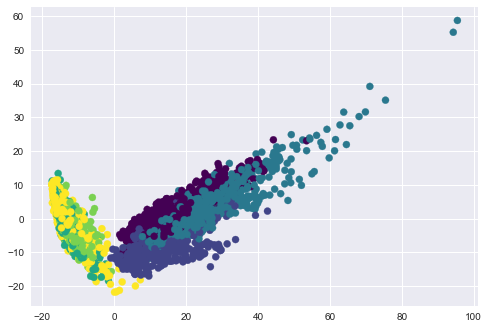

In [10]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=50, cmap='viridis');

**Видим, что отчетливо выделяются 2 группы активности – ходьба (в том числе вверх и вниз) и все остальное.**

**Зафиксируем объект StratifiedKFold, с его помощью будет проводить кросс-валидацию.**

In [12]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

**Используйте sklearn-обертку Xgboost для оценки доли правильных ответов на кросс-валидации с данными (X_train_pca, y_train). Укажите параметр XGBClassifier seed=17 (это то же по сути, что random_state), остальные оставьте по умолчанию. Используйте ранее созданный объект StratifiedKFold.**

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [15]:
xgb_model1 = XGBClassifier(seed=RANDOM_SEED)
np.mean(cross_val_score(xgb_model1, X_train_pca, y_train, cv=skf))

0.92206197777280208

**<font color='red'>Вопрос 1.</font> Какова средняя доля правильных ответов Xgboost на кросс-валидации? Округлите до 3 знаков после разделителя.**

**Сделайте все то же для случайного леса из 100 деревьев, параметр random_state укажите равным 17.**

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
forest = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
np.mean(cross_val_score(forest, X_train_pca, y_train, cv=skf))

0.92573333937526436

**<font color='red'>Вопрос 2.</font> Какова средняя доля правильных ответов случайного леса на кросс-валидации? Округлите до 3 знаков после разделителя.**

**Постройте кривые валидации по глубине деревьев для Xgboost. Все прочие параметры кросс-валидации возьмите как на предыдущем шаге. Достаточно сохранять только среднюю долю правильных ответов на валидационной части (на обучающей – не обязательно).**

In [18]:
%%time
tree_depths = np.arange(5, 11)
xgb_scores = []
for depth in tqdm(tree_depths):
    xgb_scores.append(np.mean(cross_val_score(XGBClassifier(seed=RANDOM_SEED, max_depth=depth), 
                                              X_train_pca, y_train, cv=skf)))

100%|██████████| 6/6 [02:00<00:00, 20.44s/it]

CPU times: user 7min 3s, sys: 50.5 s, total: 7min 53s
Wall time: 2min


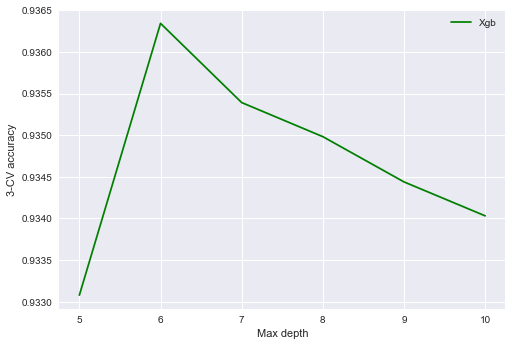

In [19]:
plt.plot(tree_depths, xgb_scores, color='green', label='Xgb');
plt.xlabel('Max depth')
plt.ylabel('3-CV accuracy')
plt.legend();

**Используйте RandomizedGridSearch, чтобы настроить параметры бустинга. Задайте 10 итераций (будут перебираться случайные 10 комбинаций параметров), а кросс-валидацию – как ранее. Не забудьте про random_state=17. Выведите лучшие параметры и accuracy (поля best\_params\_ и best\_score\_ у обученного RandomizedGridSearch).**

In [20]:
from sklearn.model_selection import RandomizedSearchCV

In [22]:
xgb_params_dist_grid = {
    'max_depth': np.arange(5, 11),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': [0.5, 0.75, 1.],
    'colsample_bytree': [0.5, 0.75, 1.]
}
xgb_params_fixed = {
    'n_estimators': 10,
    'silent': 1,
    'seed': RANDOM_SEED
}

In [23]:
xgb_grid = RandomizedSearchCV(
    XGBClassifier(**xgb_params_fixed),
    xgb_params_dist_grid,
    cv=3, random_state=RANDOM_SEED,
    n_iter=10, verbose=1)

In [24]:
%%time
xgb_grid.fit(X_train_pca, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.4s finished


CPU times: user 1min 11s, sys: 11.6 s, total: 1min 23s
Wall time: 20.5 s


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=17, silent=1, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': array([ 5,  6,  7,  8,  9, 10]), 'gamma': array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ]), 'subsample': [0.5, 0.75, 1.0], 'colsample_bytree': [0.5, 0.75, 1.0]},
          pre_dispatch='2*n_jobs', random_state=17, refit=True,
          return_train_score=True, scoring=None, verbose=1)

In [25]:
xgb_grid.best_params_, xgb_grid.best_score_

({'colsample_bytree': 0.75, 'gamma': 0.5, 'max_depth': 10, 'subsample': 0.75},
 0.83310663764961912)

**<font color='red'>Вопрос 3.</font> Каково лучшее (из перебранных) значение средней доли правильных ответов Xgboost на кросс-валидации? Округлите до 3 знаков после разделителя.**

**Проверьте доли правильных ответов настроенного и изначального бустинга на оставленной выборке.**

In [26]:
xgb_model2 = XGBClassifier(**xgb_grid.best_params_)

In [27]:
xgb_model1.fit(X_train_pca, y_train)
xgb_model2.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.75,
       gamma=0.5, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

In [28]:
print(accuracy_score(y_test, xgb_model1.predict(X_test_pca)))
print(accuracy_score(y_test, xgb_model2.predict(X_test_pca)))

0.879538513743
0.893790295215


**<font color='red'>Вопрос 4.</font> Каковы доли правильных ответов Xgboost на отложенной выборке до настройки параметров и после нее? Округлите до 3 знаков после разделителя.**

**Наконец, подберем число итераций бустинга. Общее правило: чем меньше темп обучения (learning_rate) и больше итераций (деревьев), тем точнее будет найден минимум функции ошибки и, соответственно, выше будет качество классификации. Но, естественно, тем дольше бустинг будет обучаться. Укажем learning_rate=0.03 (остальные параметры возьмем те же, что нашел *RandomizedGridSearchCV*) и построим кривые валидации Xgboost по числу итераций (до 300) с помощью функции cv из xgboost.**

In [29]:
from xgboost import cv, DMatrix

In [30]:
# каприз Xgboost: надо чтоб метки были от 0 до n_classes-1
y_train -= 1
y_test -= 1

In [31]:
dtrain = DMatrix(X_train_pca, y_train)

In [32]:
best_xgb_params = {'colsample_bytree': 0.75, 'gamma': 0.5, 
                   'max_depth': 10, 'subsample': 0.75,
                    'silent': 1, 'learning_rate': 0.03,
                   'eval_metric': 'merror',
                   'num_class': 6,
                    'seed': RANDOM_SEED}

In [35]:
%%time
cv_result = cv(params=best_xgb_params, dtrain=dtrain, num_boost_round=300, seed=RANDOM_SEED)

CPU times: user 3min 19s, sys: 36.1 s, total: 3min 55s
Wall time: 1min


In [36]:
cv_result.head()

,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
0,0.175646,0.010055,0.076735,0.002803
1,0.131293,0.007009,0.036871,0.001071
2,0.112109,0.010456,0.025986,0.001669
3,0.109388,0.007795,0.021293,0.002083
4,0.103946,0.008832,0.018232,0.001205


In [37]:
def plot_with_err(index, means, stds=None, **kwargs):
    lines = plt.plot(index, means, '-', **kwargs)
    plt.fill_between(index, means - stds, means + stds, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

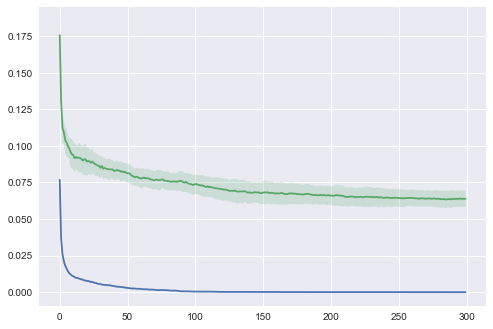

In [38]:
plot_with_err(cv_result.index, cv_result['train-merror-mean'], 
              cv_result['train-merror-std']);
plot_with_err(cv_result.index, cv_result['test-merror-mean'], 
              cv_result['test-merror-std']);

**Проверьте долю правильных ответов последней версии бустинга (с 300 итерациями) на оставленной выборке. Используйте функцию train из xgboost. X_test также надо будет переделать в DMatrix, только ответы y_test туда уже не передавайте.**

In [39]:
from xgboost import train

In [41]:
%%time
final_xgb = train(params=best_xgb_params, dtrain=dtrain, num_boost_round=300)

CPU times: user 1min 37s, sys: 14.3 s, total: 1min 51s
Wall time: 27 s


**<font color='red'>Вопрос 5.</font> Какова доля правильных ответов Xgboost с большим числом итераций и малым шагом на отложенной выборке? Округлите до 3 знаков после разделителя.**

In [42]:
dtest = DMatrix(X_test_pca, y_test)

In [43]:
accuracy_score(y_test, final_xgb.predict(dtest))

0.8961655921275874